In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

as_df = pd.read_excel('/content/sample_data/AS_final_cleaned_normalized.xlsx')
normal_df = pd.read_excel('/content/sample_data/normal_final_cleaned_normalized.xlsx')

as_df['AS_label'] = 1
normal_df['AS_label'] = 0

df = pd.concat([as_df, normal_df], ignore_index=True)

feature_cols = [col for col in df.columns if col != 'AS_label' and np.issubdtype(df[col].dtype, np.number)]
X = df[feature_cols]
y = df['AS_label']

# Stratified splits: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [6]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_imputed   = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_imputed  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)

rf.fit(X_train_imputed, y_train)
mlp.fit(X_train_imputed, y_train)

# Hybrid (Voting) Model: soft voting = average of class probabilities
hybrid = VotingClassifier(estimators=[('rf', rf), ('mlp', mlp)], voting='soft')
hybrid.fit(X_train_imputed, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(128, 64),
                                            max_iter=500, random_state=42))],
                 voting='soft')

In [8]:
# Use only imputed validation/test sets
val_preds = hybrid.predict(X_val_imputed)
test_preds = hybrid.predict(X_test_imputed)
val_probs = hybrid.predict_proba(X_val_imputed)[:, 1]
test_probs = hybrid.predict_proba(X_test_imputed)[:, 1]

print('Validation Classification Report:')
print(classification_report(y_val, val_preds))
print('Validation ROC-AUC:', roc_auc_score(y_val, val_probs))

print('Test Classification Report:')
print(classification_report(y_test, test_preds))
print('Test ROC-AUC:', roc_auc_score(y_test, test_probs))

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.91      0.95        11

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22

Validation ROC-AUC: 1.0
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.91      0.95        11

    accuracy                           0.96        23
   macro avg       0.96      0.95      0.96        23
weighted avg       0.96      0.96      0.96        23

Test ROC-AUC: 1.0


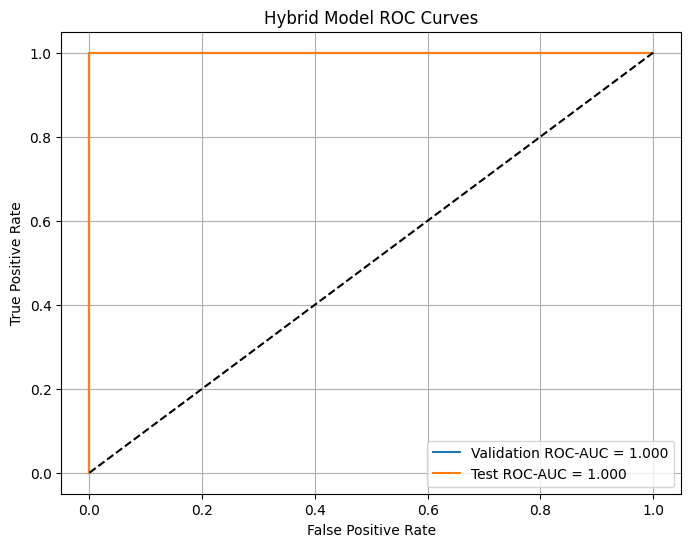

In [9]:
fpr_val, tpr_val, _ = roc_curve(y_val, val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr_val, tpr_val, label=f'Validation ROC-AUC = {roc_auc_score(y_val, val_probs):.3f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC-AUC = {roc_auc_score(y_test, test_probs):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Model ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score

print("Validation accuracy:", accuracy_score(y_val, val_preds))
print("Test accuracy:", accuracy_score(y_test, test_preds))

print("Validation precision (macro):", precision_score(y_val, val_preds, average='macro'))
print("Test precision (macro):", precision_score(y_test, test_preds, average='macro'))

Validation accuracy: 0.9545454545454546
Test accuracy: 0.9565217391304348
Validation precision (macro): 0.9583333333333333
Test precision (macro): 0.9615384615384616


In [11]:
import joblib

# Save the trained hybrid ensemble model
joblib.dump(hybrid, 'hybrid_model.joblib')
print("Hybrid model saved as hybrid_model.joblib")

Hybrid model saved as hybrid_model.joblib
